In [13]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import fastplotlib as fpl
import mbo_utilities as mbo
import lbm_suite2p_python as lsp
import suite2p

# Load Data

In [ ]:
# data = mbo.imread(r"D:\W2_DATA\kbarber\2025_07_17\mk355\green")
# mbo.imwrite(data, r"D:\W2_DATA\kbarber\2025_07_17\mk355\green\processed", planes=[1, 2, 3], roi=0)

# files = list(Path(r"D:\W2_DATA\kbarber\2025_07_17\mk355\green\processed").glob("*.tif"))
# ops = suite2p.default_ops()
# ops["roidetect"] = False
#
# lsp.run_volume(files, ops=ops)

In [10]:
def plot_suite2p_masks(ops, stat, iscell, proj=None, plot_indices=None, savepath=None,
       color_mode='random', red_border=False, colors=None):
    ops = lsp.load_ops(ops)
    img = ops[proj]

    # Infer offsets from ops
    xr0, xr1 = ops.get("xrange", [0, ops["Lx"]])
    yr0, yr1 = ops.get("yrange", [0, ops["Ly"]])

    H_img, W_img = img.shape

    p1, p99 = np.percentile(img, 1), np.percentile(img, 99)
    norm_img = np.clip((img - p1) / (p99 - p1), 0, 1)

    H = np.zeros_like(norm_img)
    S = np.zeros_like(norm_img)
    mask = np.zeros_like(norm_img, dtype=bool)

    iscell = np.asarray(iscell)
    cell_mask = iscell if iscell.ndim == 1 else iscell[:, 0]
    indices = np.flatnonzero(cell_mask) if plot_indices is None else plot_indices

    for i, n in enumerate(indices):
        s = stat[n]
        ypix = np.array(s["ypix"]) - yr0
        xpix = np.array(s["xpix"]) - xr0

        # suite2p crops pixels
        valid = (ypix >= 0) & (ypix < H_img) & (xpix >= 0) & (xpix < W_img)
        ypix = ypix[valid]
        xpix = xpix[valid]

        mask[ypix, xpix] = True

        if colors is not None:
            hue = lsp.rgb_to_hsv(np.array([[colors[i][:3]]]))[0, 0, 0]
        elif color_mode == "random":
            hue = np.random.rand()
        elif color_mode == "uniform":
            hue = 0.6
        else:
            hue = (i / max(len(indices), 1)) % 1.0

        H[ypix, xpix] = hue
        S[ypix, xpix] = 1

    rgb = lsp.hsv_to_rgb(np.stack([H, S, norm_img], axis=-1))

    if red_border and mask.any():
        from skimage.segmentation import find_boundaries
        borders = find_boundaries(mask, mode="outer")
        rgb[borders] = [1, 0, 0]

    plt.figure(figsize=(8, 8))
    plt.imshow(rgb)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def merge_rois(roi1, folder2, output_folder):
    roi1 = Path(folder1)
    roi1 = Path(folder2)
    output_folder = Path(output_folder)
    output_folder.mkdir(exist_ok=True)

    ops1 = np.load(folder1 / "ops.npy", allow_pickle=True).item()
    ops2 = np.load(folder2 / "ops.npy", allow_pickle=True).item()
    stat1 = np.load(folder1 / "stat.npy", allow_pickle=True)
    stat2 = np.load(folder2 / "stat.npy", allow_pickle=True)

    def uncorrect_crop(stat, xoff, yoff, H):
        for s in stat:
            s["xpix"] = np.array(s["xpix"]) + xoff
            s["ypix"] = np.array(s["ypix"]) + yoff
            if "ipix_neuropil" in s:
                s["ipix_neuropil"] = np.array(s["ipix_neuropil"]) + (xoff * H + yoff)
        return stat

    xoff1, yoff1 = ops1["xrange"][0], ops1["yrange"][0]
    xoff2, yoff2 = ops2["xrange"][0], ops2["yrange"][0]
    H = ops1["Ly"]

    stat1 = uncorrect_crop(stat1, xoff1, yoff1, H)
    stat2 = uncorrect_crop(stat2, xoff2, yoff2, H)

    h1, w1 = ops1["meanImg"].shape
    h2, w2 = ops2["meanImg"].shape
    assert h1 == h2, "Heights must match for horizontal stitching"
    H, W = h1, w1 + w2

    def shift_stat(stat, dx):
        shifted = []
        for s in stat:
            s2 = s.copy()
            s2["xpix"] = np.array(s2["xpix"]) + dx
            if "med" in s2:
                s2["med"] = [s2["med"][0], s2["med"][1] + dx]
            shifted.append(s2)
        return np.array(shifted, dtype=object)

    stat2 = shift_stat(stat2, dx=w1)
    stat_merged = np.concatenate([stat1, stat2])
    np.save(output_folder / "stat.npy", stat_merged)

    def cat(fname, astype=None):
        d1 = np.load(folder1 / fname)
        d2 = np.load(folder2 / fname)
        if astype:
            d1 = d1.astype(astype)
            d2 = d2.astype(astype)
        return np.concatenate([d1, d2], axis=0)

    np.save(output_folder / "F.npy", cat("F.npy"))
    np.save(output_folder / "Fneu.npy", cat("Fneu.npy"))
    np.save(output_folder / "spks.npy", cat("spks.npy"))
    np.save(output_folder / "iscell.npy", cat("iscell.npy", astype=bool))

    def hcat(a, b):
        return np.hstack([np.array(a, dtype=np.float32), np.array(b, dtype=np.float32)])

    ops_merged = {}
    ops_merged["meanImg"] = hcat(ops1["meanImg"], ops2["meanImg"])
    if "meanImgE" in ops1 and "meanImgE" in ops2:
        ops_merged["meanImgE"] = hcat(ops1["meanImgE"], ops2["meanImgE"])
    if "max_proj" in ops1 and "max_proj" in ops2:
        ops_merged["max_proj"] = hcat(ops1["max_proj"], ops2["max_proj"])
    if "Vcorr" in ops1 and "Vcorr" in ops2:
        ops_merged["Vcorr"] = hcat(ops1["Vcorr"], ops2["Vcorr"])
    if "refImg" in ops1 and "refImg" in ops2:
        ops_merged["refImg"] = hcat(ops1["refImg"], ops2["refImg"])

    ops_merged["xrange"] = [0, W]
    ops_merged["yrange"] = [0, H]
    ops_merged["Lx"] = W
    ops_merged["Ly"] = H
    ops_merged["crop_offset_x"] = 0
    ops_merged["crop_offset_y"] = 0

    np.save(output_folder / "ops.npy", ops_merged)

    redcell_path = output_folder / "redcell.npy"
    if not redcell_path.exists():
        np.save(redcell_path, np.zeros((len(stat_merged), 2), dtype=np.float32))


In [4]:
from pathlib import Path
import numpy as np
import shutil

def embed_into_full_frame(cropped, yrange, xrange, Ly, Lx):
    full = np.zeros((Ly, Lx), dtype=cropped.dtype)
    full[yrange[0]:yrange[1], xrange[0]:xrange[1]] = cropped
    return full

def merge_rois(roi_left, roi_right, save_path):
    roi_left = Path(roi_left)
    roi_right = Path(roi_right)
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    ops_left = np.load(roi_left / "ops.npy", allow_pickle=True).item()
    ops_right = np.load(roi_right / "ops.npy", allow_pickle=True).item()
    stat_left = np.load(roi_left / "stat.npy", allow_pickle=True)
    stat_right = np.load(roi_right / "stat.npy", allow_pickle=True)
    iscell_left = np.load(roi_left / "iscell.npy", allow_pickle=True)
    iscell_right = np.load(roi_right / "iscell.npy", allow_pickle=True)

    # Confirm matching Y dims
    assert ops_left['Ly'] == ops_right['Ly'], "Mismatched Ly"
    Ly = ops_left['Ly']
    Lx_left = ops_left['Lx']
    Lx_right = ops_right['Lx']
    Lx = Lx_left + Lx_right

    # Offset right ROIs by Lx_left
    for s in stat_right:
        s['xpix'] = s['xpix'] + Lx_left
        s['med'][1] = s['med'][1] + Lx_left
        if 'ipix_neuropil' in s:
            s['ipix_neuropil'] = s['ipix_neuropil'] + Lx_left * Ly

    stat_merged = np.concatenate([stat_left, stat_right], axis=0)
    iscell_merged = np.concatenate([iscell_left, iscell_right], axis=0)
    
    def merge_traces(name):
        left = np.load(roi_left / name)
        right = np.load(roi_right / name)
        return np.concatenate([left, right], axis=0)

    F = merge_traces("F.npy")
    Fneu = merge_traces("Fneu.npy")
    spks = merge_traces("spks.npy")

    # Create merged ops
    ops_merged = dict(ops_left)
    ops_merged['Lx'] = Lx
    ops_merged['xrange'] = [0, Lx]
    ops_merged['yrange'] = [0, Ly]
    if 'meanImg' in ops_left and 'meanImg' in ops_right:
        ops_merged['meanImg'] = np.hstack([ops_left['meanImg'], ops_right['meanImg']])
    if 'meanImgE' in ops_left and 'meanImgE' in ops_right:
        ops_merged['meanImgE'] = np.hstack([ops_left['meanImgE'], ops_right['meanImgE']])

    if 'Vcorr' in ops_left and 'Vcorr' in ops_right:
        Vcorr_left = embed_into_full_frame(ops_left['Vcorr'], ops_left['yrange'], ops_left['xrange'],
                                           ops_left['Ly'], ops_left['Lx'])
        Vcorr_right = embed_into_full_frame(ops_right['Vcorr'], ops_right['yrange'], ops_right['xrange'],
                                            ops_right['Ly'], ops_right['Lx'])
    
        ops_merged['Vcorr'] = np.hstack([Vcorr_left, Vcorr_right])

    np.save(save_path / "ops.npy", ops_merged)
    np.save(save_path / "stat.npy", stat_merged)
    np.save(save_path / "iscell.npy", iscell_merged)
    np.save(save_path / "F.npy", F)
    np.save(save_path / "Fneu.npy", Fneu)
    np.save(save_path / "spks.npy", spks)

In [11]:
from pathlib import Path
import re

def merge_all_rois_in_plane(root_dir, merge_fn):
    """
    Merge all Suite2p ROI subfolders for each plane into a single folder named 'planeN'.

    Parameters
    ----------
    root_dir : str or Path
        Directory containing Suite2p ROI folders (e.g. plane01_roi1, plane2_roi2).
    merge_fn : callable
        Function(roi1_path, roi2_path, output_path) that merges two Suite2p ROI folders.
    """
    root_dir = Path(root_dir)
    plane_groups = {}

    for f in root_dir.iterdir():
        if f.is_dir() and "roi" in f.name.lower():
            match = re.search(r"plane[_]?(?P<num>\d+)", f.name.lower())
            if match:
                plane_num = int(match.group("num"))  # Strip leading zero
                plane_groups.setdefault(plane_num, []).append(f)

    for plane_num, rois in plane_groups.items():
        if len(rois) < 2:
            continue

        rois = sorted(rois, key=lambda x: x.name.lower())
        merged = rois[0]

        for roi in rois[1:]:
            output_path = root_dir / f"plane{plane_num}"
            merge_fn(merged, roi, output_path)
            merged = output_path

        print(f"Merged {len(rois)} ROI folders for plane{plane_num} -> {merged.name}")

In [53]:
base_dir = Path("D:/W2_DATA/kbarber/2025_07_17/mk355/green/processed")

In [ ]:
merge_all_rois_in_plane(base_dir, merge_fn=merge_rois)

Merged 2 ROI folders for plane1 -> plane1
Merged 2 ROI folders for plane2 -> plane2
Merged 2 ROI folders for plane3 -> plane3
Merged 2 ROI folders for plane4 -> plane4
Merged 2 ROI folders for plane5 -> plane5
Merged 2 ROI folders for plane6 -> plane6
Merged 2 ROI folders for plane7 -> plane7
Merged 2 ROI folders for plane8 -> plane8
Merged 2 ROI folders for plane9 -> plane9
Merged 2 ROI folders for plane10 -> plane10
Merged 2 ROI folders for plane11 -> plane11
Merged 2 ROI folders for plane12 -> plane12
Merged 2 ROI folders for plane13 -> plane13
Merged 2 ROI folders for plane14 -> plane14


In [61]:
def load_mean_imgs(base_dir):
    base_dir = Path(base_dir)
    mean_imgs = {}

    counter = 1
    for plane_folder in sorted(base_dir.iterdir()):
        if not plane_folder.is_dir():
            continue
        if not plane_folder.name.startswith("plane"):
            continue
        if "_" in plane_folder.name:
            continue  # exclude plane01_roi1 etc.

        ops_path = plane_folder / "ops.npy"
        if ops_path.exists():
            ops = np.load(ops_path, allow_pickle=True).item()
            mimg = ops.get("meanImg", None)
            plane = ops.get("plane", counter)
            mean_imgs[int(plane)] = mimg
            counter += 1

    return mean_imgs

In [64]:
base_dir = Path("D:/W2_DATA/kbarber/2025_07_17/mk355/green/processed")
means = load_mean_imgs(base_dir)
means.keys()

dict_keys([1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9])

In [65]:
volume = np.empty((14, *means[1].shape), dtype=means[1].dtype)
volume.shape

(14, 550, 440)

In [67]:
for idx, key in enumerate(sorted(means)):
    volume[idx, ...] = means[int(key)]

In [68]:
summ = np.load(r"D:\W2_DATA\kbarber\2025_07_17\mk355\green\processed\job\s3d-test1\summary\summary.npy", allow_pickle=True).item()
# stat_left = np.load(roi_left / "stat.npy", allow_pickle=True)
plane_shifts = summ["plane_shifts"]

In [80]:
def shift_with_padding(img, dy, dx):
    H, W = img.shape
    shifted = np.zeros_like(img)

    y_src_start = max(0, -dy)
    y_src_end   = min(H, H - dy) if dy < 0 else H
    y_dst_start = max(0, dy)
    y_dst_end   = min(H, H + dy) if dy > 0 else H

    x_src_start = max(0, -dx)
    x_src_end   = min(W, W - dx) if dx < 0 else W
    x_dst_start = max(0, dx)
    x_dst_end   = min(W, W + dx) if dx > 0 else W

    y_len = min(y_src_end - y_src_start, y_dst_end - y_dst_start)
    x_len = min(x_src_end - x_src_start, x_dst_end - x_dst_start)

    shifted[y_dst_start:y_dst_start + y_len, x_dst_start:x_dst_start + x_len] = \
        img[y_src_start:y_src_start + y_len, x_src_start:x_src_start + x_len]

    return shifted

In [ ]:
volume = np.moveaxis(volume, -1, -2)

volume_shifted = np.empty_like(volume)
for idx, (dy, dx) in enumerate(plane_shifts):
    volume_shifted[idx] = shift_with_padding(volume[idx], dy, dx)

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
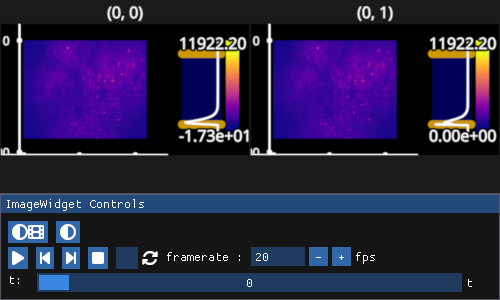

In [82]:
import fastplotlib as fpl
fpl.ImageWidget([volume, volume_shifted]).show()

In [ ]:
folder1 = base_dir / "plane01_roi1"
folder2 = base_dir / "plane01_roi2"
output_folder = base_dir / "plane_01_roi1_roi2"

merge_rois(folder1, folder2, output_folder)

ops_merged = lsp.load_ops(output_folder / "ops.npy")
stat_merged = np.load(output_folder / "stat.npy", allow_pickle=True)
iscell_merged = np.load(output_folder / "iscell.npy")

NameError: name 'lsp' is not defined

In [14]:
output_folder

NameError: name 'output_folder' is not defined

In [ ]:
mean_images = mbo.get_files()

In [38]:
ops_merged["Vcorr"].shape

(550, 440)

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_suite2p_rois(ops, stat, iscell, show_overlap=False, plot_indices=None):
    mean_img = ops["meanImg"]
    Ly, Lx = mean_img.shape
    mask_img = np.zeros((Ly, Lx), dtype=np.int32)

    iscell = np.asarray(iscell)
    cell_mask = iscell[:, 0] > 0
    indices = np.flatnonzero(cell_mask) if plot_indices is None else plot_indices

    for n, i in enumerate(indices, start=1):
        s = stat[i]
        ypix = np.array(s['ypix'])
        xpix = np.array(s['xpix'])
        if not show_overlap and 'overlap' in s:
            keep = ~np.array(s['overlap'])
            ypix = ypix[keep]
            xpix = xpix[keep]
        mask_img[ypix, xpix] = n

    plt.figure(figsize=(10, 10))
    plt.imshow(mean_img, cmap='gray', interpolation='none')
    plt.imshow(mask_img, cmap='nipy_spectral', alpha=0.5, interpolation='none')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
ops_merged = lsp.load_ops(output_folder / "ops.npy")
stat_merged = np.load(output_folder / "stat.npy", allow_pickle=True)
iscell_merged = np.load(output_folder / "iscell.npy")

In [30]:
ops_merged['meanImg'].shape == (ops_merged['Ly'], ops_merged['Lx'])

True

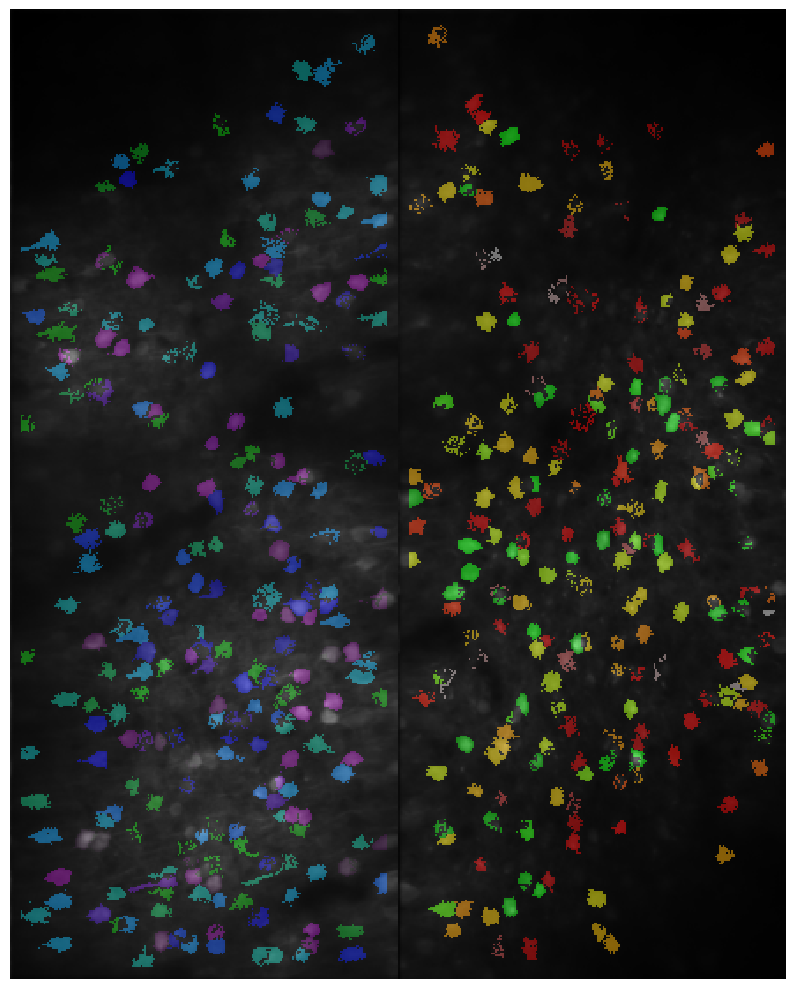

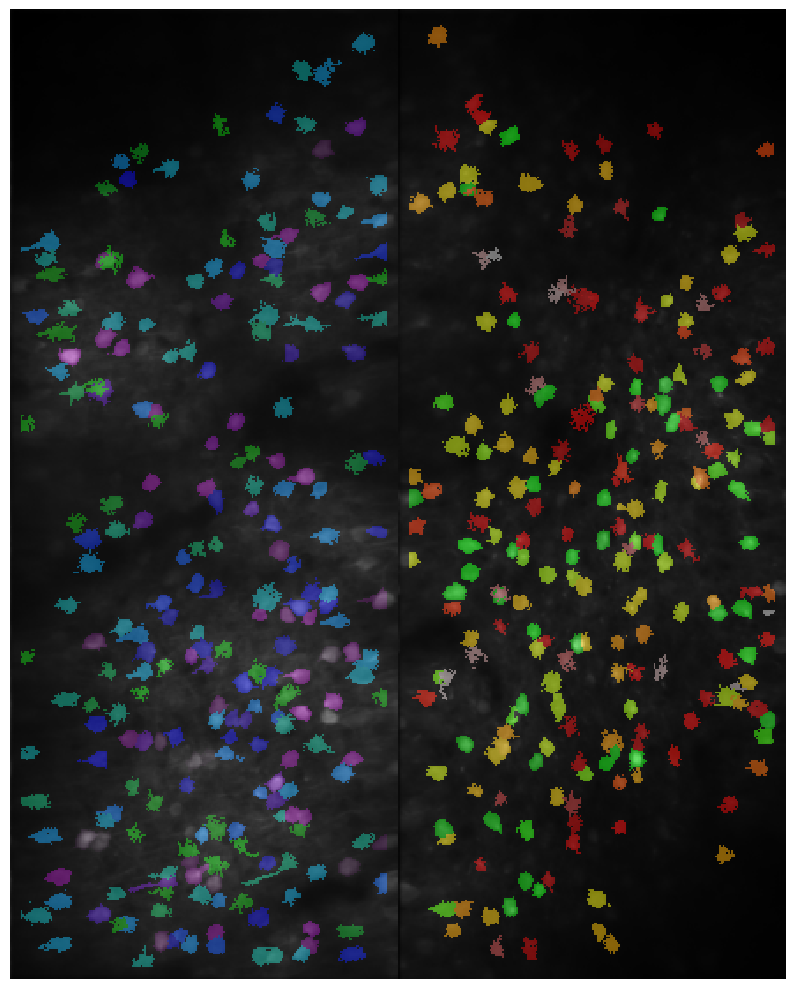

In [ ]:
plot_suite2p_rois(ops_merged, stat_merged, iscell_merged, show_overlap=False)
plot_suite2p_rois(ops_merged, stat_merged, iscell_merged, show_overlap=True)

In [ ]:
folder1 = r"D:\W2_DATA\kbarber\2025_07_17\mk355\green\processed\plane01_roi1"
folder2 = r"D:\W2_DATA\kbarber\2025_07_17\mk355\green\processed\plane01_roi2"
output_folder = r"D:\W2_DATA\kbarber\2025_07_17\mk355\green\processed\plane_01_roi1_roi2"
merge_rois_horizontal(folder1, folder2, output_folder)

In [ ]:
ops_merged = lsp.load_ops("D:/W2_DATA/kbarber/2025_07_17/mk355/green/processed/plane_01_roi1_roi2/ops.npy")
stat_merged = np.load("D:/W2_DATA/kbarber/2025_07_17/mk355/green/processed/plane_01_roi1_roi2/stat.npy", allow_pickle=True)
iscell_merged = np.load("D:/W2_DATA/kbarber/2025_07_17/mk355/green/processed/plane_01_roi1_roi2/iscell.npy")
ov(ops_merged, stat_merged, iscell_merged, proj="max_proj", color_mode="random")

ops1 = np.load(folder1 + "/ops.npy", allow_pickle=True).item()
stat1 = np.load(folder1 + "/stat.npy", allow_pickle=True)
iscell1 = np.load(folder1 + "/iscell.npy", allow_pickle=True)
ov(ops1, stat1, iscell1, proj="max_proj", color_mode="random")

ops2 = np.load(folder2 + "/ops.npy", allow_pickle=True).item()
stat2 = np.load(folder2 + "/stat.npy", allow_pickle=True)
iscell2 = np.load(folder2 + "/iscell.npy", allow_pickle=True)
ov(ops_merged, stat_merged, iscell_merged, proj="max_proj")
# lsp.suite2p_roi_overlay(ops2, stat2, iscell2, "max_proj", color_mode="random")

##

from lbm_suite2p_python import load_ops
from lbm_suite2p_python import rgb_to_hsv, hsv_to_rgb

from lbm_suite2p_python import load_ops, rgb_to_hsv, hsv_to_rgb
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# ov(ops1, stat1, iscell1, proj="max_proj", color_mode="random")
ov(ops_merged, stat_merged, iscell_merged, proj="max_proj", color_mode="random")

print(f"roi1 mean-image shape: {ops1['meanImg'].shape}")
print(f"roi2 mean-image shape: {ops2['meanImg'].shape}")
print(f"merged mean-image shape: {ops_merged['meanImg'].shape}")

print(f"roi1 xrange: {ops1['xrange']}, yrange: {ops1['yrange']}")
print(f"roi2 xrange: {ops2['xrange']}, yrange: {ops2['yrange']}")
print(f"merged xrange: {ops_merged['xrange']}, yrange: {ops_merged['yrange']}")

print(f"Example ROI 1: {stat1[0]}")

ops1["xrange"][0], ops1["yrange"][0], ops2["xrange"][0], ops2["yrange"][0], ops_merged["xrange"][0], ops_merged["yrange"][0]

In [16]:
ops1["meanImg"].shape

(550, 220)